<h1 align="center">OpenSAFELY Service Restoration Observatory (SRO) - Changes in key GP measures during the pandemic (Demographics)</h1>

The aim of the OpenSAFELY SRO is to describe trends and variation in clinical activity codes to evaluate NHS service restoration during the COVID-19 pandemic.

The purpose of this notebook is to provide a demographic breakdown of key GP measures, that are indicative of changes in overall activity during the pandemic.  For each of these measures we provide a link to the codelist containing all the codes used for that measure, a description of what the measure is and a brief overview of why the measure is important.  We also highlight any caveats, where there are any, for each measure.  For each measure monthly population level rates of recorded activity are provided as well as break downs by sex, ethnicity, imd, region, learning disabilities status and age group.

The following key measures are provided:
* [Blood Pressure Monitoring](#systolic_bp)
* [Cardiovascular Disease 10 Year Risk Assessment](#qrisk2)
* [Cholesterol Testing](#cholesterol)
* [Liver Function Testing - Alanine Transferaminase (ALT)](#ALT)
* [Thyroid Testing](#serum_tsh)
* [Full Blood Count - Red Blood Cell (RBC) Testing](#rbc_fbc)
* [Glycated Haemoglobin A1c Level (HbA1c)](#hba1c)
* [Renal Function Assessment - Sodium Testing](#serum_sodium)
* [Asthma Reviews](#asthma)
* [Chronic Obstrutive Pulmonary Disease (COPD) Reviews](#copd)

In [103]:
from IPython.display import HTML
import pandas as pd
import matplotlib.pyplot as plt
from utilities import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [104]:
sentinel_measures = ["qrisk2", "asthma", "copd", "sodium", "cholesterol", "alt", "tsh", "alt", "rbc", 'hba1c', 'systolic_bp']

demographics = ['region', 'sex', 'imd', 'learning_disability', 'age_band', 'ethnicity']

data_dict = {}
data_dict_totals = {}


for measure in sentinel_measures:
    
    demographics_dict = {}
    
    for d in demographics:
        df = pd.read_csv(f'../output/measure_{measure}_{d}.csv')
        df = redact_small_numbers(df, 5, [measure, 'population'])
        
        if d == 'age_band':
            df = calculate_rate(df, measure, 'population', standardise=False)
            
        else:
            df = calculate_rate(df, measure, 'population', standardise=True, age_group_column='age_band')
        
        if d == 'imd':
            df = calculate_imd_group(df, measure, 'rate_standardised')
        
        elif d == 'ethnicity':
            df = convert_ethnicity(df)
        
        
        if d== 'age_band':
            df = df.groupby(by=[d, 'date'])['rate'].mean().reset_index()
            
        else:
            df = df.groupby(by=[d, 'date'])['rate_standardised'].mean().reset_index()
        
        demographics_dict[d] = df
            
    data_dict[measure] = demographics_dict
    
    
    total_df = pd.read_csv(f'../output/measure_{measure}.csv')
    total_df = calculate_rate(total_df, measure, 'population', standardise=False)
    data_dict_totals[measure] = total_df.groupby(by=['date'])['rate'].mean().reset_index()
    

In [105]:
def plot_demographics(data_dict, data_totals, demographics):
    fig = go.Figure()
    buttons_list = []
    visible_list = []
    
    #add population rate
    fig.add_trace(go.Scatter(
                    x=data_totals['date'], y=data_totals['rate'], name='total', visible=True))
    
    
    for d in demographics:
        df = data_dict[d]
        
        
        visible_list.append(len(df[d].unique()))
        for unique_category in df[d].unique():

                df_subset = df[df[d] == unique_category]
                
                if d == 'age_band':
                    
                    fig.add_trace(go.Scatter(
                    x=df_subset['date'], y=df_subset['rate'], name=str(unique_category), visible=False))
                else:
                    fig.add_trace(go.Scatter(
                    x=df_subset['date'], y=df_subset['rate_standardised'], name=str(unique_category), visible=False))
    
    
    buttons_list.append(
        dict(label = 'Total Population Rate',
                      method = 'update',
                      args = [{'visible': [True] + [False]*sum(visible_list)},
                              {'title': 'Total Population Rate',
                               'showlegend':True}])
        )
        

    for i, d in enumerate(demographics):
        
        
        
        
        visible=[False]
        for j, x in enumerate(visible_list):
            if i == j:
                visible.extend([True]*x)
            else:
                visible.extend([False]*x)
        
        
        
        
        buttons_list.append(
        dict(label = d,
                      method = 'update',
                      args = [{'visible': visible},
                              {'title': d,
                               'showlegend':True}])
        )
    
    
    fig.update_layout(
    updatemenus=[
        dict(active=0,
            buttons=buttons_list,
            direction="down",
            pad={"r": 10, "t": 10},
           
            x=1.0,
            xanchor="left",
            y=1.3,
            yanchor="top"
        ),
    ]
)

    
    
    
    # Set title
    fig.update_layout(
        hovermode='x',
        title_x=0.5,


    )

    fig.update_yaxes(title='Age standardised rate per 1000')
    fig.update_xaxes(title="Date")

    # Add range slider
    fig.update_layout(
        xaxis=go.layout.XAxis(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1m",
                        step="month",
                        stepmode="backward"),
                    dict(count=6,
                        label="6m",
                        step="month",
                        stepmode="backward"),

                    dict(count=1,
                        label="1y",
                        step="year",
                        stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig.show()

<a id="systolic_bp"></a>
### Blood Pressure Monitoring

The codes used in for this measure are available in <a href="https://codelists.opensafely.org/codelist/user/richard-croker/systolic-blood-pressure-qof/3572b5fb/">this codelist</a>.

#### What it is
Rate of systolic blood presure monitoring per 1000 members of the population.

#### Why it matters
* The measurement of blood pressure and identification and management of hypertension is important for both primary and secondary prevention of cardiovascular disease, such as stroke, myocardial infarction and kidney disease. 
* If patients cannot have their blood pressure measurements acted on by primary care, they may not benefit from averting associated complications. 
* Active management and prevention of these complications is generally provided by Primary Care; as a measure it would therefore be considered an important marker of access to and provision of care.

#### Caveats
None

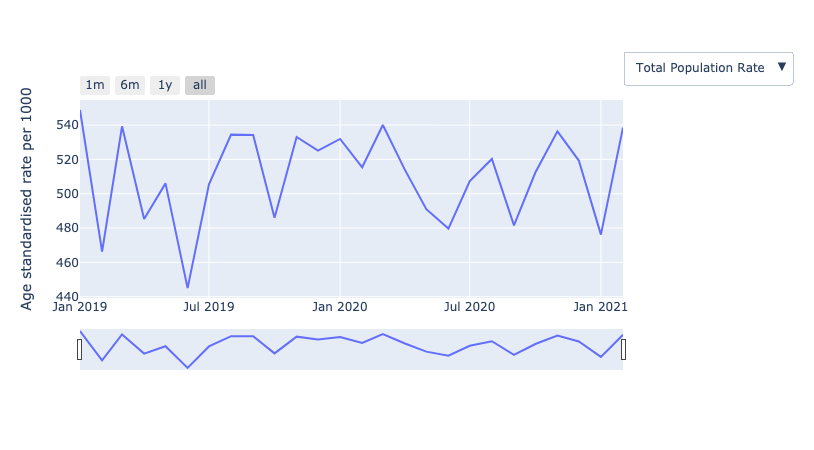

In [106]:
plot_demographics(data_dict['systolic_bp'], data_dict_totals['systolic_bp'],demographics)

<a id="qrisk"></a>
### Cardiovascular Disease 10 year Risk Assessment

The codes used in for this measure are available in <a href="https://codelists.opensafely.org/codelist/user/richard-croker/cvd-risk-assessment-score-qof/1adf44a5/">this codelist</a>.

#### What it is
Rate of cardiovascular disease risk assessments performed per 1000 members of the population.

#### Why it matters
* Primary prevention of cardiovascular disease is recommended in all people above the age of 40 year, and in particular people with clinical conditions such as hypertension and diabetes are at greater risk. To determine an individual's risk of a cardiovascular event such as a myocardial infarction or stroke, an algorithm called QRISK2 is recommended. This estimates the likelihood of a cardiovascular event in the next 10 years, and individuals with a risk of at least 10% should have a discussion with their GP about starting a statin, or blood pressure treatment if they have Stage I hypertension.  
* If patients are not receiving these risk assessments due to the COVID-19 pandemic, these higher risk patients may not be identified and effective preventative treatment may not be commenced.
* Such risk factor assessment generally only occurs in primary care; it would therefore be considered an important marker of the provision and access to basic preventative care. So for example, the risk calculation requires at least a single cholesterol test and blood pressure readings.

#### Caveats
None

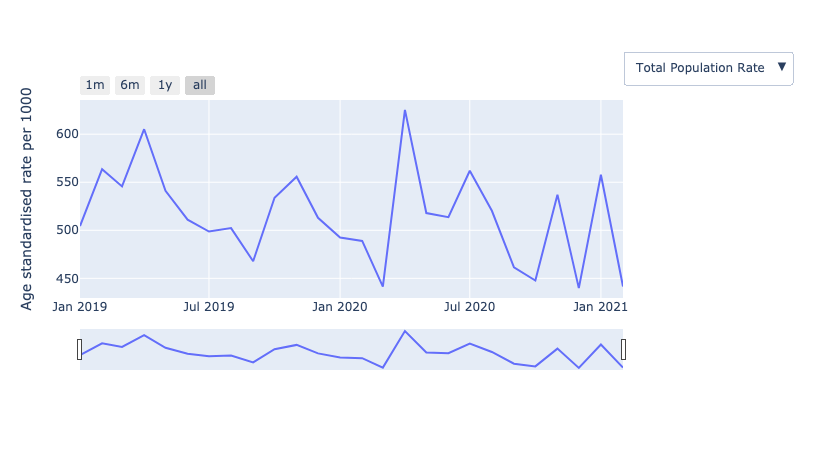

In [107]:
plot_demographics(data_dict['qrisk2'], data_dict_totals['qrisk2'],demographics)

<a id="cholesterol"></a>
### Cholesterol Testing

The codes used in for this measure are available in <a href="https://codelists.opensafely.org/codelist/user/richard-croker/cholesterol-tests-numerical-value/7dee4fa4/">this codelist</a>.

#### What it is
Rate of total cholesterol tests performed per 1000 members of the population.

#### Why it matters
* Cholesterol tests are used to estimate your risk of cardiovacular disease and to monitor treatment with cholesterol modifying drugs.  You can read more about this test and when it should be used <a href="https://labtestsonline.org.uk/tests/cholesterol-test">here</a>.
* As with most blood tests, there has been debate about the appropriate level of testing but we have presented the information here to inform recovery from COVID-19 in order to “build back better”.

#### Caveats
Here, we use codes which represent results reported to GPs, so tests requested but not yet reported are not included. This will usually exclude tests requested while a person is in hospital and other settings, like a private clinic.

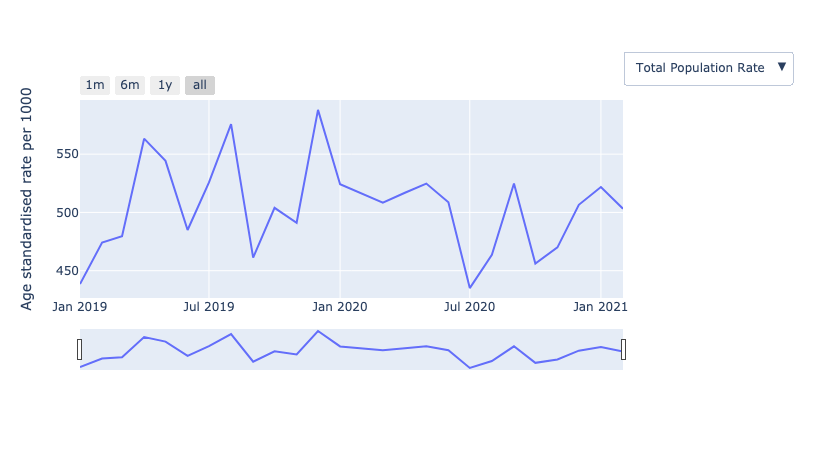

In [108]:
plot_demographics(data_dict['cholesterol'], data_dict_totals['cholesterol'],demographics)

<a id="ALT"></a>
### Liver Function Testing - Alanine Transferaminase (ALT)

The codes used in for this measure are available in <a href="https://codelists.opensafely.org/codelist/user/richard-croker/alanine-aminotransferase-alt-tests-numerical-value/16fdc2da/">this codelist</a>.

#### What it is
Rate of ALT tests performed per 1000 members of the population.

#### Why it matters
* ALT tests blood tests are used as a part of Liver Function Testing, a group of tests which detect problems with liver function. You can read more about this test and when it should be used <a href="https://labtestsonline.org.uk/tests/alanine-aminotransferase-alt-test">here</a>.
* As with most blood tests, there has been debate about the appropriate level of testing but we have presented the information here to inform recovery from COVID-19 in order to “build back better”.

#### Caveats
**In a small number of places, an ALT test may NOT be included within a liver function test.** We use codes which represent results reported to GPs so tests requested but not yet reported are not included. Only tests results returned to GPs are included, which will usually exclude tests requested while a person is in hospital and other settings like a private clinic.

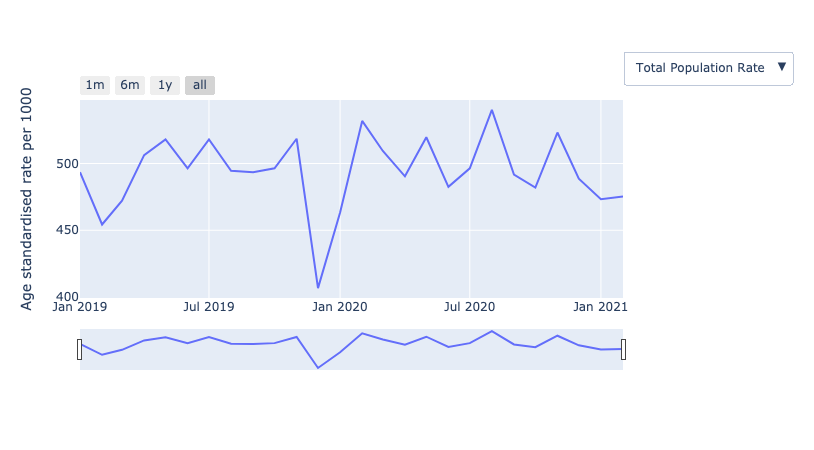

In [109]:
plot_demographics(data_dict['alt'], data_dict_totals['alt'],demographics)

<a id="serum_tsh"></a>
### Thyroid Testing

The codes used in for this measure are available in <a href="https://codelists.opensafely.org/codelist/user/richard-croker/thyroid-stimulating-hormone-tsh-tests-numerical-value/1c6342c6/">this codelist</a>.

#### What it is
Rate of thyroid-stimulating hormone (TSH) tests performed per 1000 members of the population.

#### Why it matters
* Thyroid stimulating hormone (TSH) is a blood test used for diagnosis and monitoring of hypothyroidism and hyperthyroidism. You can read more about this test and <a href="https://labtestsonline.org.uk/tests/thyroid-stimulating-hormone-tsh">when TSH should be used here </a>and NICE have produced guidance on the assessment and <a href="https://www.nice.org.uk/guidance/ng145/chapter/recommendations">management of thyroid disease here</a>. 
* As with most blood tests, there has been debate about the appropriate level of testing but we have presented the information here to inform recovery from COVID-19 in order to “build back better”.

#### Caveats
Here, we use codes which represent results reported to GPs, so tests requested but not yet reported are not included. This will usually exclude tests requested while a person is in hospital and other settings, like a private clinic.

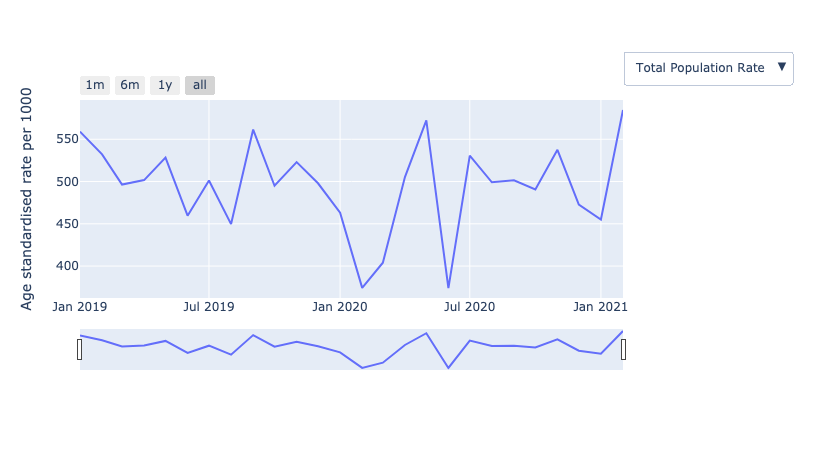

In [110]:
plot_demographics(data_dict['tsh'], data_dict_totals['tsh'],demographics)

<a id="rbc_fbc"></a>
### Full Blood Count - Red Blood Cell (RBC) Testing

The codes used in for this measure are available in <a href="https://codelists.opensafely.org/codelist/user/richard-croker/red-blood-cell-rbc-tests-numerical-value/64dedc6f/">this codelist</a>.

#### What it is
Rate of RBC count tests performed per 1000 members of the population.

#### Why it matters
* RBC count tests are used as a part of a Full Blood Count, a group of tests which can detect a variety of disorders of the blood, such as anaemia and infection. You can read more about this test and when it should be used <a href="https://labtestsonline.org.uk/tests/red-blood-cell-count">here</a>.
*  As with most blood tests, there has been debate about the appropriate level of testing but we have presented the information here to inform recovery from COVID-19 in order to “build back better”.

#### Caveats
Here, we use codes which represent results reported to GPs, so tests requested but not yet reported are not included. This will usually exclude tests requested while a person is in hospital and other settings, like a private clinic.

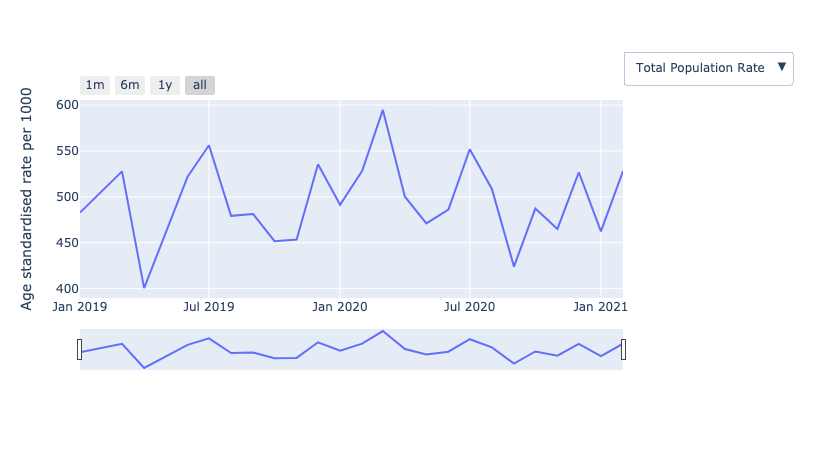

In [111]:
plot_demographics(data_dict['rbc'], data_dict_totals['rbc'],demographics)

<a id="hba1c"></a>
### Glycated Haemoglobin A1c Level (HbA1c)

The codes used in for this measure are available in <a href="https://codelists.opensafely.org/codelist/user/richard-croker/glycated-haemoglobin-hba1c-tests/62358576/">this codelist</a>.

#### What it is
Rate of HbA1c tests performed per 1000 members of the population.

#### Why it matters
* HbA1c is a measure of blood glucose levels. It is used to make the diagnosis of type 2 diabetes as well as to monitor the average blood glucose in those with recorded diabetes. It is recommended that everyone with diabetes has HbA1c measured at least twice a year.
* If HbA1c is not been monitored regularly, patients may not be identified as having poor diabetes control, and therefore there is a greater risk of complications.  You can read more about this test and when it should be used <a href="https://labtestsonline.org.uk/tests/hba1c-test">here</a>.
*  As with most blood tests, there has been debate about the appropriate level of testing but we have presented the information here to inform recovery from COVID-19 in order to “build back better”.

#### Caveats
Here, we use codes which represent results reported to GPs, so tests requested but not yet reported are not included. This will usually exclude tests requested while a person is in hospital and other settings, like a private clinic.

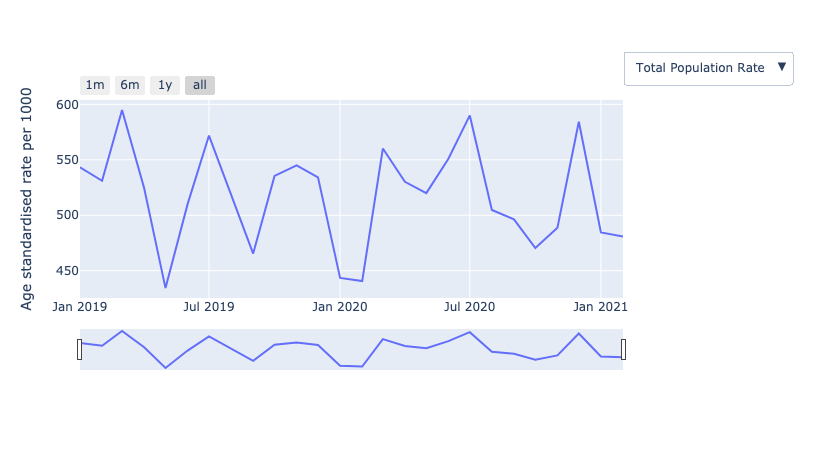

In [112]:
plot_demographics(data_dict['hba1c'], data_dict_totals['hba1c'],demographics)

<a id="serum_sodium"></a>
### Renal Function Assessment - Sodium Testing

The codes used in for this measure are available in <a href="https://codelists.opensafely.org/codelist/user/richard-croker/sodium-tests-numerical-value/32bff605/">this codelist</a>.

#### What it is
Rate of sodium blood tests performed per 1000 members of the population.

#### Why it matters
* Sodium blood test is used to detect the cause and help monitor treatment in persons with dehydration, oedema, or with a variety of symptoms. It is routinely tested for with other blood electrolytes including those used to detect kidney disease. You can read more about <a href="https://labtestsonline.org.uk/tests/sodium-test">sodium tests and when it should be used here</a>.
*  As with most blood tests, there has been debate about the appropriate level of testing but we have presented the information here to inform recovery from COVID-19 in order to “build back better”.

#### Caveats
Here, we use codes which represent results reported to GPs, so tests requested but not yet reported are not included. This will usually exclude tests requested while a person is in hospital and other settings, like a private clinic.

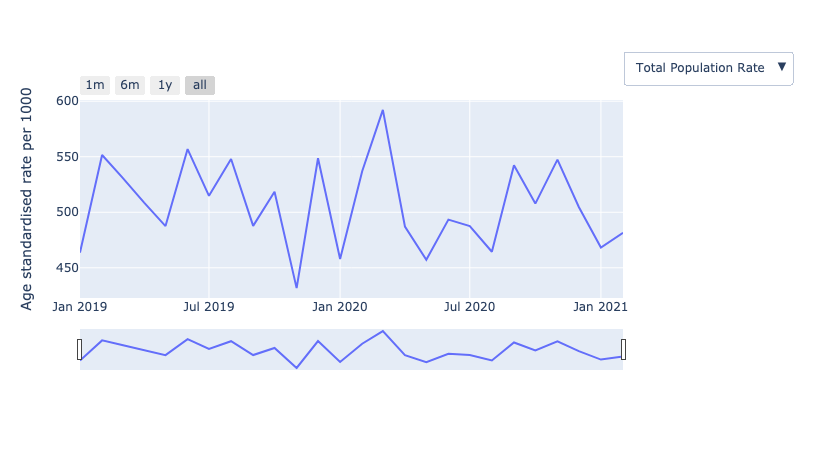

In [113]:
plot_demographics(data_dict['sodium'], data_dict_totals['sodium'],demographics)

<a id="asthma"></a>
### Asthma Reviews

The codes used in for this measure are available in <a href="https://codelists.opensafely.org/codelist/user/richard-croker/asthma-annual-review-qof/33eeb7da/">this codelist</a>.  QoF recommends a number of codes that can be used by practices as an asthma annual review.  These are all included in our codelist.

#### What it is
Rate of asthma reviews performed per 1000 members of the population.

#### Why it matters
* It is recommended that people with asthma receive a review of their condition at least annually, in order to ensure that their asthma is well controlled and that they are using their inhalers correctly.  The Royal College of Physicians recommends three questions in order to assess the patient’s asthma control:
    * Have you had difficulty sleeping because of your asthma symptoms (including cough)?
    * Have you had your usual asthma symptoms during the day (e.g. cough, wheeze, chest tightness, or breathlessness)?
    * Has your asthma interfered with your usual activities (e.g. housework, work, school)?
* If patients have not received an annual during the time of the pandemic, it is possible that their asthma control may have worsened, leading to greater chance of symptoms and admission.

#### Caveats
None

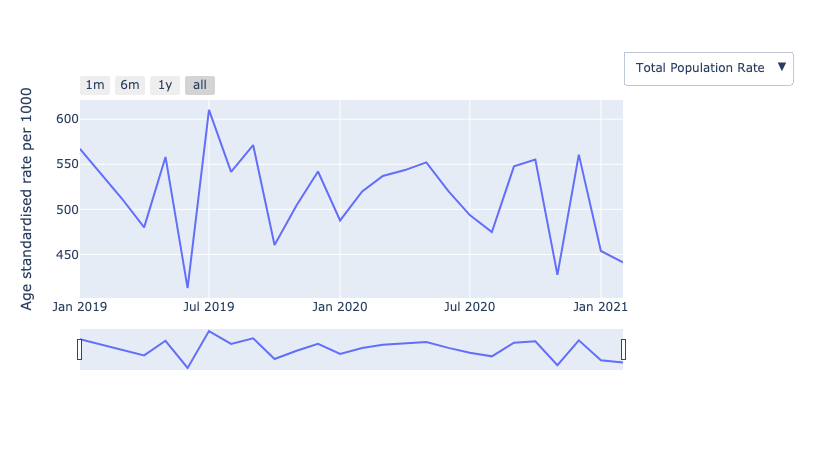

In [114]:
plot_demographics(data_dict['asthma'], data_dict_totals['asthma'],demographics)

<a id="copd"></a>
### Chronic Obstructive Pulmonary Disease (COPD) Reviews

The codes used in for this measure are available in <a href="https://codelists.opensafely.org/codelist/user/richard-croker/chronic-obstructive-pulmonary-disease-copd-review-qof/01cfd170/">this codelist</a>.  

#### What it is
Rate of COPD reviews performed per 1000 members of the population.

#### Why it matters
* It is <a href="https://www.nice.org.uk/guidance/ng115/chapter/Recommendations">recommended by NICE</a> that all individuals living with COPD have an annual review, with individuals with very severe (stage 4) COPD being reviewed at least twice a year.
* The purpose of the review is multifaceted, but includes, for example, smoking cessation support, review of symptoms and optimising treatment. The annual COPD review is also a feature of <a href="https://www.england.nhs.uk/wp-content/uploads/2020/09/C0713-202021-General-Medical-Services-GMS-contract-Quality-and-Outcomes-Framework-QOF-Guidance.pdf">QOF</a>, which supports practices to deliver quality care.
* As COPD is a chronic progressive disease with significant morbidity and mortality (especially in more severe cases), a reduction in reviews due to the COVID-19 pandemic could not only lead to worsening disease (and associated complications) but also significant social and economic detriment. 
#### Caveats
None

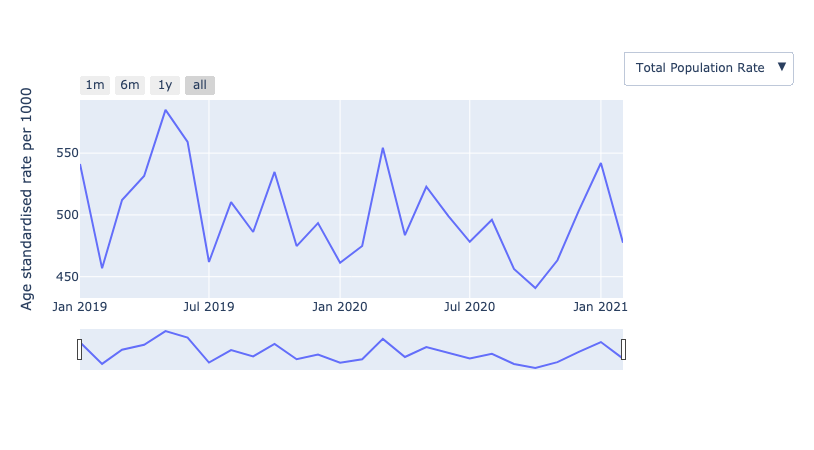

In [115]:
plot_demographics(data_dict['copd'], data_dict_totals['copd'],demographics)